## Permutation Invariance
In this notebook, we evaluate the results from the ```check_permutation_invariance_llm.py``` script.
Results were stored in the llm_permutationtest_2000triplets_5repeats.csv file.

In [ ]:
import pandas as pd
from facesim3d import local_paths


results_dir = local_paths.DIR_LLM_ANALYSIS_RESULTS
df = pd.read_csv(os.path.join(results_dir, "llm_permutationtest_200triplets_30repeats.csv"))
df = df.rename(columns={"idx": "dataset_idx"})
df.head(20)

,dataset_idx,repeat_id,perm_order,llm_answer,llm_regions,llm_prediction_id
0,1168,0,"[0, 2, 1]",1,nose_bridge,3
1,1168,1,"[1, 2, 0]",1,nose_bridge,3
2,1168,2,"[0, 1, 2]",2,nose_bridge,3
3,1168,3,"[2, 1, 0]",1,nose_bridge,97
4,1168,4,"[1, 0, 2]",2,nose_bridge,3
5,1168,5,"[2, 0, 1]",1,nose_bridge,92
6,1168,6,"[1, 2, 0]",1,nose_bridge,3
7,1168,7,"[1, 0, 2]",2,nose_bridge,3
8,1168,8,"[1, 2, 0]",1,nose_bridge,3
9,1168,9,"[0, 2, 1]",1,nose_bridge,3


In [ ]:
# load the csv with the ground truth data for each index
gt_dir = local_paths.DIR_SINGLE_HJ_HEATMAPS
gt_df = pd.read_csv(os.path.join(gt_dir, "single_heatmaps_metadata.csv"))
gt_df.head()

,dataset_idx,head1,head2,head3,gt_odd_head,model_pred,human_choice_index,correct,heatmap_file
0,112139,13,98,14,98,1,1,1,triplet112139_pred_head098.npy
1,8677,44,61,69,44,0,0,1,triplet08677_pred_head044.npy
2,89702,22,34,39,22,0,0,1,triplet89702_pred_head022.npy
3,79468,44,81,29,29,2,2,1,triplet79468_pred_head029.npy
4,25396,20,19,85,19,1,1,1,triplet25396_pred_head019.npy


In [3]:
# count predictions per triplet
pred_counts = (
    df.groupby("dataset_idx")["llm_prediction_id"]
      .value_counts()
      .rename("count")
      .reset_index()
)

In [4]:
print(pred_counts)

     dataset_idx  llm_prediction_id  count
0           1168                  3     23
1           1168                 97      5
2           1168                 92      2
3           1285                 32     17
4           1285                 89      7
..           ...                ...    ...
571       184785                 26      9
572       184785                 25      7
573       185252                 34     21
574       185252                 45      6
575       185252                 65      3

[576 rows x 3 columns]


### check consistency and variance of predictions

In [42]:
# Approach 2: categorical variance
def categorical_variance(group):
    p = group["llm_prediction_id"].value_counts(normalize=True) # computes frequency for each prediction in a triplet
    return 1 - p.max() # substracts the frequency from the most chosen face-ID

var_categorical = df.groupby("dataset_idx").apply(categorical_variance) # this now holds the inconsistency for all other than the most chosen face-ID within a triplet
var_categorical # 0 = chosen the same ID over all trials, 0.67 = predictions are evenly distributed across all options

dataset_idx
1168      0.233333
1285      0.433333
1526      0.600000
3777      0.400000
4259      0.433333
            ...   
183250    0.100000
183261    0.566667
183527    0.533333
184785    0.533333
185252    0.300000
Length: 200, dtype: float64

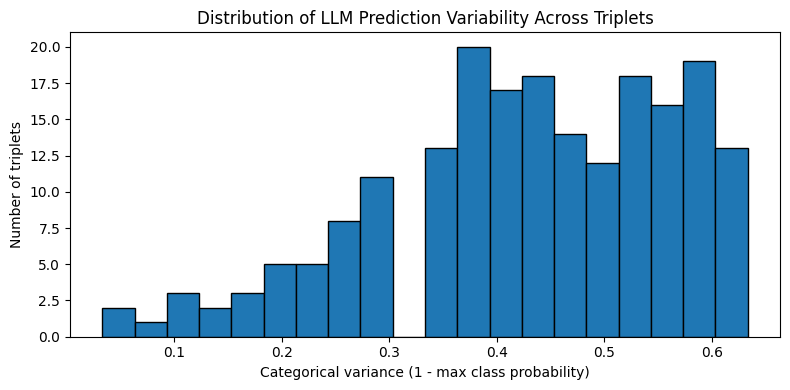

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(var_categorical, bins=20, edgecolor='black')
plt.xlabel("Categorical variance (1 - max class probability)")
plt.ylabel("Number of triplets")
plt.title("Distribution of LLM Prediction Variability Across Triplets")
plt.tight_layout()
plt.savefig("llm_categorical_variance.png")
plt.show()

## 1. check how often the model predicts accurately

In [5]:
# extract most frequent choices (if two are the same, it chooses the one thats listed first, so maybe misleading)
most_freq_pred = (
    pred_counts.sort_values(["dataset_idx", "count"], ascending=[True, False])
               .drop_duplicates(subset=["dataset_idx"])
               .rename(columns={"llm_prediction_id": "predicted_id"})
)

In [6]:
print(most_freq_pred)

     dataset_idx  predicted_id  count
0           1168             3     23
3           1285            32     17
6           1526            13     12
9           3777            18     18
12          4259            75     17
..           ...           ...    ...
562       183250            89     27
564       183261            95     13
567       183527             5     14
570       184785            88     14
573       185252            34     21

[200 rows x 3 columns]


In [7]:
# merge the dataframes
merged = most_freq_pred.merge(gt_df[["dataset_idx", "gt_odd_head"]], on="dataset_idx", how="left")

In [8]:
merged.head()

,dataset_idx,predicted_id,count,gt_odd_head
0,1168,3,23,92
1,1285,32,17,32
2,1526,13,12,13
3,3777,18,18,18
4,4259,75,17,75


In [9]:
# get average accuracy
merged["is_correct"] = merged["predicted_id"] == merged["gt_odd_head"]
accuracy = merged["is_correct"].mean()
print("LLM repetition majority-vote accuracy:", accuracy)

LLM repetition majority-vote accuracy: 0.455


In [10]:
# get average consistency
merged["consistency"] = pred_counts.groupby("dataset_idx")["count"].max().values
mean_consistency = merged["consistency"].mean()
print("LLM consistency on average (how often the most predicted ID is chosen out of 30 trials)", mean_consistency)

LLM consistency on average (how often the most predicted ID is chosen out of 30 trials) 17.115


In [11]:
merged.head(10)

,dataset_idx,predicted_id,count,gt_odd_head,is_correct,consistency
0,1168,3,23,92,False,23
1,1285,32,17,32,True,17
2,1526,13,12,13,True,12
3,3777,18,18,18,True,18
4,4259,75,17,75,True,17
5,5273,32,17,32,True,17
6,10627,29,11,95,False,11
7,11873,7,12,91,False,12
8,11911,10,15,10,True,15
9,12092,19,19,19,True,19


## 2. Correlation between Permutation and Prediction per Triplet 

In [5]:
import ast

df["perm_order"] = df["perm_order"].apply(ast.literal_eval)
df["perm_str"] = df["perm_order"].astype(str)

In [7]:
from scipy.stats import chi2_contingency
import pandas as pd
import numpy as np

def chi2_per_triplet(group):
    contingency = pd.crosstab(
        group["perm_str"],
        group["llm_prediction_id"]
    )

    N = contingency.values.sum()

    # Not enough variability → no valid chi² test
    if contingency.shape[0] < 2 or contingency.shape[1] < 2:
        return pd.Series({
            "chi2": np.nan,
            "dof": np.nan,
            "N": N,
            "p_value": 1.0,
            "min_expected": np.nan
        })

    chi2, p, dof, expected = chi2_contingency(contingency)

    return pd.Series({
        "chi2": chi2,
        "dof": dof,
        "N": N,
        "p_value": p,
        "min_expected": expected.min()
    })


In [9]:
results = (df.groupby("dataset_idx").apply(chi2_per_triplet).reset_index())
results.head()

,dataset_idx,chi2,dof,N,p_value,min_expected
0,1168,60.000000,10.0,30.0,3.624301e-09,0.133333
1,1285,60.000000,10.0,30.0,3.624301e-09,0.600000
2,1526,60.000000,10.0,30.0,3.624301e-09,0.600000
3,3777,43.166667,10.0,30.0,4.643129e-06,0.066667
4,4259,60.000000,10.0,30.0,3.624301e-09,0.266667


In [16]:
# add report

results["chi2_report"] = (
    "χ²(" + results["dof"].astype("Int64").astype(str) +
    ", N=" + results["N"].astype(int).astype(str) +
    ") = " + results["chi2"].round(3).astype(str) +
    ", p = " + results["p_value"].round(4).astype(str)
)
results = results.drop(columns = ["chi2", "dof", "N", "p_value", "min_expected"])
results.head()

,dataset_idx,chi2_report
0,1168,"χ²(10, N=30) = 60.0, p = 0.0"
1,1285,"χ²(10, N=30) = 60.0, p = 0.0"
2,1526,"χ²(10, N=30) = 60.0, p = 0.0"
3,3777,"χ²(10, N=30) = 43.167, p = 0.0"
4,4259,"χ²(10, N=30) = 60.0, p = 0.0"


In [18]:
#save
results.to_latex(
    "chi2_results_appendix.tex",
    index=False,
    longtable=True,
    float_format="%.4f",
    escape=False   
)

/tmp/ipykernel_1723005/3643856953.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  results.to_latex(


In [12]:
p_values = results["p_value"]
significant = p_values < 0.05
print("Percentage of triplets where permutation influences prediction:", significant.mean())

Percentage of triplets where permutation influences prediction: 0.995


In [32]:
# no correlation
significant[significant == False]

dataset_idx
129502    False
dtype: bool

In [35]:
# show in df
df[df["dataset_idx"] == 129502]

,dataset_idx,repeat_id,perm_order,llm_answer,llm_regions,llm_prediction_id,perm_str
2580,129502,0,"[0, 1, 2]",1,mouth,8,"[0, 1, 2]"
2581,129502,1,"[1, 2, 0]",0,mouth,8,"[1, 2, 0]"
2582,129502,2,"[2, 1, 0]",1,mouth,8,"[2, 1, 0]"
2583,129502,3,"[2, 0, 1]",2,mouth,8,"[2, 0, 1]"
2584,129502,4,"[0, 1, 2]",1,mouth,8,"[0, 1, 2]"
2585,129502,5,"[0, 2, 1]",2,mouth,8,"[0, 2, 1]"
2586,129502,6,"[0, 1, 2]",1,mouth,8,"[0, 1, 2]"
2587,129502,7,"[0, 1, 2]",1,mouth,8,"[0, 1, 2]"
2588,129502,8,"[1, 2, 0]",0,mouth,8,"[1, 2, 0]"
2589,129502,9,"[0, 2, 1]",2,mouth/left_cheek/right_cheek,8,"[0, 2, 1]"


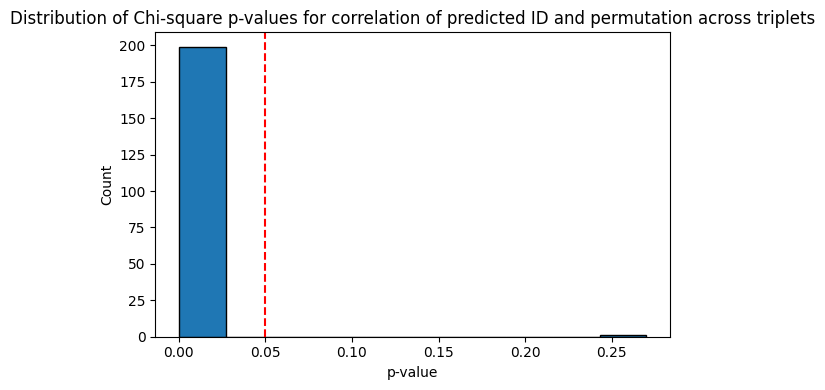

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(p_values, bins=10, edgecolor='black')
plt.axvline(0.05, color='red', linestyle='--')
plt.xlabel("p-value")
plt.ylabel("Count")
plt.title("Distribution of Chi-square p-values for correlation of predicted ID and permutation across triplets")
plt.tight_layout()
plt.show()

### 4. Correlation between Permutation and predicted Region per Triplet 

In [36]:
from scipy.stats import chi2_contingency
import pandas as pd

def chi2_perm_vs_region(group):
    contingency = pd.crosstab(group["perm_str"], group["llm_regions"])
    
    # If not enough variation, no correlation is possible
    if contingency.shape[0] < 2 or contingency.shape[1] < 2:
        return 1.0  # no evidence of correlation

    chi2, p, _, _ = chi2_contingency(contingency)
    return p

In [37]:
p_values_regions = df.groupby("dataset_idx").apply(chi2_perm_vs_region)

In [38]:
significant_region_perm = p_values_regions < 0.05
print("Fraction of triplets where permutation influences REGION choice:", significant_region_perm.mean())

Fraction of triplets where permutation influences REGION choice: 0.845


In [41]:
# no correlation
print(f"Number of not-significant samples", len(significant_region_perm[significant_region_perm == False]))
significant_region_perm[significant_region_perm == False]

Number of not-significant samples 31


dataset_idx
1168      False
13108     False
13897     False
18909     False
30572     False
34406     False
35412     False
64088     False
71856     False
90991     False
100610    False
101293    False
112558    False
114932    False
123873    False
126366    False
128384    False
129502    False
131973    False
133339    False
140370    False
142431    False
142574    False
147262    False
155192    False
159633    False
171881    False
174547    False
180007    False
182784    False
183261    False
dtype: bool

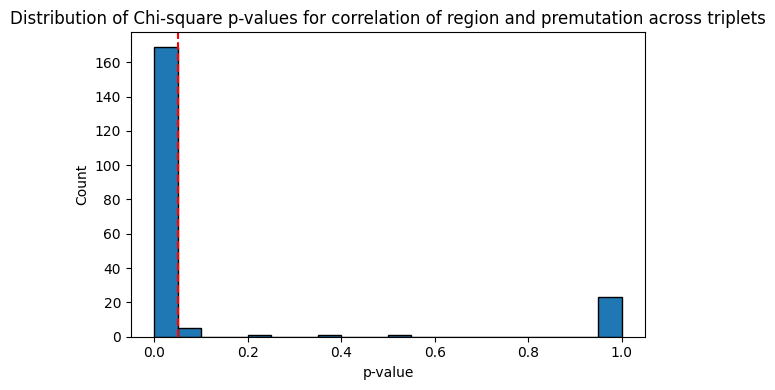

In [50]:
plt.figure(figsize=(6,4))
plt.hist(p_values_regions, bins=20, edgecolor='black')
plt.axvline(0.05, color='red', linestyle='--')
plt.xlabel("p-value")
plt.ylabel("Count")
plt.title("Distribution of Chi-square p-values for correlation of region and premutation across triplets")
plt.tight_layout()
plt.show()